In [8]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [9]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel
#ring MRF for travelling wave
#last column connected back to the first column

In [10]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,-1].reshape(p,-1,1),w,w[:,:,0].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var)*(pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2)
    return np.exp(-tau*(E_x+E_s))

In [11]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,-1].reshape(p,-1,1),pi_l,pi_l[:,:,0].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [12]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,-1].reshape(p,-1,1),pi_r,pi_r[:,:,0].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [13]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [14]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [15]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,var,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_r_star,var,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [16]:
def simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return s

In [30]:
var,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,10,10,0,1/100,0.5*np.ones((100,7,7)),7,100,11000,
s = simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample)

In [18]:
def corr(x,y):
    return (np.mean(x*y)-np.mean(x)*np.mean(y))/(np.var(x)*np.var(y))**0.5

In [19]:
def autocorr(x,y,n):
    #x, y: arrays to calculate correlation
    #n: cover correlation rxy(0) to rxy(n-1)
    rxy = []
    for i in range(n):
        y_shift = np.concatenate((np.zeros(i),y[:(len(y)-i)]))
        rxy.append(corr(x,y_shift))
    return np.array(rxy)

In [31]:
s = np.array(s)
autocorr_s_0 = autocorr(s[:,0,1,0],s[:,0,1,0],100)

for i in range(1,p):
    autocorr_s_0 = autocorr_s_0 + autocorr(s[:,i,1,0],s[:,i,1,0],100)
autocorr_s_0 = autocorr_s_0/p

autocorr_s_1 = autocorr(s[:,0,1,0],s[:,0,1,1],100)
for i in range(1,p):
    autocorr_s_1 = autocorr_s_1 + autocorr(s[:,i,1,0],s[:,i,1,1],100)
autocorr_s_1 = autocorr_s_1/p

autocorr_s_2 = autocorr(s[:,0,1,0],s[:,0,1,2],100)
for i in range(1,p):
    autocorr_s_2 = autocorr_s_2 + autocorr(s[:,i,1,0],s[:,i,1,2],100)
autocorr_s_2 = autocorr_s_2/p

autocorr_s_3 = autocorr(s[:,0,1,0],s[:,0,1,3],100)
for i in range(1,p):
    autocorr_s_3 = autocorr_s_3 + autocorr(s[:,i,1,0],s[:,i,1,3],100)
autocorr_s_3 = autocorr_s_3/p

autocorr_s_4 = autocorr(s[:,0,1,0],s[:,0,1,4],100)
for i in range(1,p):
    autocorr_s_4 = autocorr_s_4 + autocorr(s[:,i,1,0],s[:,i,1,4],100)
autocorr_s_4 = autocorr_s_4/p

autocorr_s_5 = autocorr(s[:,0,1,0],s[:,0,1,5],100)
for i in range(1,p):
    autocorr_s_5 = autocorr_s_5 + autocorr(s[:,i,1,0],s[:,i,1,5],100)
autocorr_s_5 = autocorr_s_5/p

autocorr_s_6 = autocorr(s[:,0,1,0],s[:,0,1,6],100)
for i in range(1,p):
    autocorr_s_6 = autocorr_s_6 + autocorr(s[:,i,1,0],s[:,i,1,6],100)
autocorr_s_6 = autocorr_s_6/p

Text(0.5, 1.0, 'autocorrelogram between nodes, concentric')

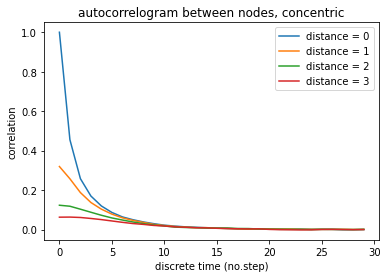

In [38]:
plt.plot(autocorr_s_0[:30])
plt.plot(autocorr_s_1[:30])
plt.plot(autocorr_s_2[:30])
plt.plot(autocorr_s_3[:30])
plt.xlabel('discrete time (no.step)')
plt.ylabel('correlation')
plt.legend(['distance = 0', 'distance = 1','distance = 2','distance = 3'])
plt.title('autocorrelogram between nodes, concentric')

In [39]:
autocorr_r_0 = autocorr(s[:,0,0,1],s[:,0,0,1],100)

for i in range(1,p):
    autocorr_r_0 = autocorr_r_0 + autocorr(s[:,i,0,1],s[:,i,0,1],100)
autocorr_r_0 = autocorr_r_0/p

autocorr_r_1 = autocorr(s[:,0,0,1],s[:,0,1,1],100)
for i in range(1,p):
    autocorr_r_1 = autocorr_r_1 + autocorr(s[:,i,0,1],s[:,i,1,1],100)
autocorr_r_1 = autocorr_r_1/p

autocorr_r_2 = autocorr(s[:,0,0,1],s[:,0,2,1],100)
for i in range(1,p):
    autocorr_r_2 = autocorr_r_2 + autocorr(s[:,i,0,1],s[:,i,2,1],100)
autocorr_r_2 = autocorr_r_2/p

autocorr_r_3 = autocorr(s[:,0,0,1],s[:,0,3,1],100)
for i in range(1,p):
    autocorr_r_3 = autocorr_r_3 + autocorr(s[:,i,0,1],s[:,i,3,1],100)
autocorr_r_3 = autocorr_r_3/p

autocorr_r_4 = autocorr(s[:,0,0,1],s[:,0,4,1],100)
for i in range(1,p):
    autocorr_r_4 = autocorr_r_4 + autocorr(s[:,i,0,1],s[:,i,4,1],100)
autocorr_r_4 = autocorr_r_4/p

autocorr_r_5 = autocorr(s[:,0,0,1],s[:,0,5,1],100)
for i in range(1,p):
    autocorr_r_5 = autocorr_r_5 + autocorr(s[:,i,0,1],s[:,i,5,1],100)
autocorr_r_5 = autocorr_r_5/p

autocorr_r_6 = autocorr(s[:,0,0,1],s[:,0,6,1],100)
for i in range(1,p):
    autocorr_r_6 = autocorr_r_6 + autocorr(s[:,i,0,1],s[:,i,6,1],100)
autocorr_r_6 = autocorr_r_6/p

Text(0.5, 1.0, 'autocorrelogram between nodes, radial')

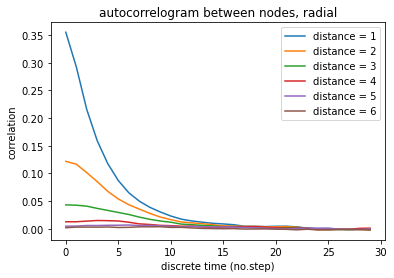

In [47]:
plt.plot(autocorr_r_1[:30])
plt.plot(autocorr_r_2[:30])
plt.plot(autocorr_r_3[:30])
plt.plot(autocorr_r_4[:30])
plt.plot(autocorr_r_5[:30])
plt.plot(autocorr_r_6[:30])

plt.xlabel('discrete time (no.step)')
plt.ylabel('correlation')
plt.legend(['distance = 1','distance = 2','distance = 3','distance = 4','distance = 5','distance = 6'])
plt.title('autocorrelogram between nodes, radial')

Text(0, 0.5, 'propagation time')

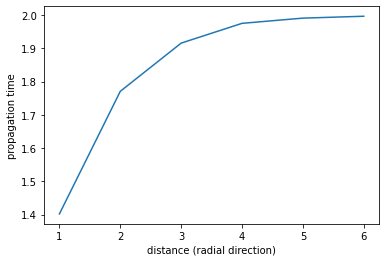

In [52]:
plt.plot(np.arange(1,7),2*np.exp(-np.array([autocorr_r_1[0],autocorr_r_2[0],autocorr_r_3[0],autocorr_r_4[0],autocorr_r_5[0],autocorr_r_6[0]])))
plt.xlabel('distance (radial direction)')
plt.ylabel('propagation time')

Text(0, 0.5, 'propagation time')

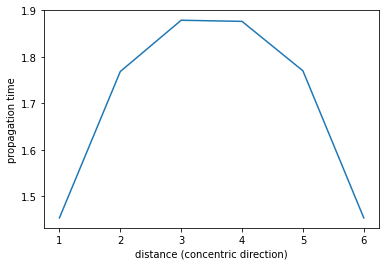

In [53]:
plt.plot(np.arange(1,7),2*np.exp(-np.array([autocorr_s_1[0],autocorr_s_2[0],autocorr_s_3[0],autocorr_s_4[0],autocorr_s_5[0],autocorr_s_6[0]])))
plt.xlabel('distance (concentric direction)')
plt.ylabel('propagation time')